## Campos involucrados

- titulo
- descripcion

## Ideas

- wordcloud
- normalizacion
- stemming
- palabras positivas (respecto al precio)
- palabras negativas (respecto al precio)

## Hipótesis

- ciertas palabras indican mayor precio (luminoso, jardín, hermoso, vista...)
- a más palabras, mayor precio

## Resultados
- la correlacion entre longitud de descripcion y precio es bastante baja (0.1)
- la correlacion entre la cantidad de palabras positivas en la descripcion y el precio es bastante alta (0.3) [tener en cuenta que metrostotales tiene correlacion 0.5]

In [40]:
#importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
#importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [ ]:
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df.columns
pd.set_option("display.max_colwidth", -1)

In [2]:
import nltk  
from nltk.corpus import stopwords  
from string import punctuation  

In [3]:
spanish_stopwords = set(stopwords.words('spanish'))
non_words = set(punctuation)
non_words.update({'¿', '¡'})
non_words.update(map(str,range(10)))

In [4]:
import re
from unidecode import unidecode

def is_meaningful(word: str) -> bool:
    """
        Recibe una palabra, remueve puntuaciones y verifica que lo que queda no esté en el set de stopwords
    """
    return len(word) > 2 and not word in spanish_stopwords

def remove_html(field: str) -> str:
    """
        Recibe un texto y devuelve una copia sin los tags html
    """
    return re.compile(r'<[^>]+>').sub('', field) if field else field

def normalize(field: str) -> str:
    """
        Recibe un texto y devuelve una copia sin acentos, ñ ni puntuaciones.
    """
    return ''.join([" " if c in non_words else unidecode(c) for c in field]).strip() if field else ""

def limpiar_campo(field: str) -> str:
    """
        Recibe un campo string que podría tener muchas palabras.
        Devuelve un string que contiene sólo las palabras significativas.
    """
    if not isinstance(field,str): return ""
    without_html = remove_html(field)
    normalized = normalize(without_html)
    meaningful = " ".join(set(filter(is_meaningful, normalized.split())))
    return meaningful

In [5]:
df["descripcion_limpia"] = df["descripcion"].map(limpiar_campo)
df["len_descripcion"] = df["descripcion_limpia"].map(lambda x: len(x.split()))

In [6]:
df["titulo_limpio"] = df["titulo"].map(limpiar_campo)
df["len_titulo"] = df["titulo_limpio"].map(lambda x: len(x.split()))

In [ ]:
plot = get_barplot(df["len_titulo"].value_counts().sort_index(), title="Palabras en título", x_label="Cantidad de palabras en título", y_label="Cantidad de publicaciones")
plot.figure.savefig("../graficos/barplot_palabras_titulo.png")

In [7]:
from collections import Counter

def get_word_counter(series):
    """
        Faltaría analizar stemming
    """
    counter = Counter()
    for title in series.values:
        counter.update(set(title.split()))
    return counter

In [8]:
titulo_palabras = get_word_counter(df["titulo_limpio"])
descripcion_palabras = get_word_counter(df["descripcion_limpia"])

In [9]:
print(len(titulo_palabras),len(descripcion_palabras))

18578 72121


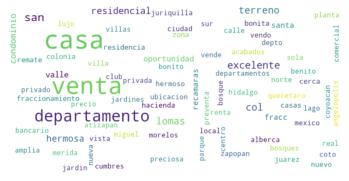

In [41]:
wc = get_wordcloud(titulo_palabras)
wc.to_file("../graficos/wordcloud_titulo.png")

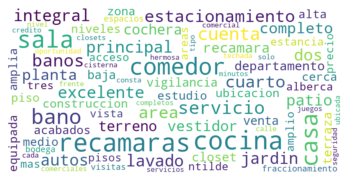

In [42]:
wc = get_wordcloud(descripcion_palabras)
wc.to_file("../graficos/wordcloud_descripcion.png")

In [ ]:
# titulo_palabras.most_common(10)

In [ ]:
# descripcion_palabras.most_common(10)

In [14]:
palabras_positivas = {"conservacion","tenis","balcon","panoramica","exclusivos","golf","canchas","remodelada","acondicionado","lujo","jacuzzi","diseno","exclusiva","magnifica","exclusivo","country","precioso","estilo","seguridad","verdes","juegos","servicio","excelente","terraza","jardin","hermosa","vista","bonita","renta", "granito"}
palabras_negativas = {"oportunidad","remato","oferta","remodelar"}

In [18]:
df["palabras_positivas_descripcion"] = df["descripcion_limpia"].map(lambda x: " ".join([y for y in x.split() if y in palabras_positivas]))
df["cantidad_palabras_positivas_descripcion"] = df["palabras_positivas_descripcion"].map(lambda x: len(x.split()))
df[["cantidad_palabras_positivas_descripcion","precio"]].corr()

,cantidad_palabras_positivas_descripcion,precio
cantidad_palabras_positivas_descripcion,1.000000,0.338492
precio,0.338492,1.000000


In [20]:
df["palabras_negativas_descripcion"] = df["descripcion_limpia"].map(lambda x: " ".join([y for y in x.split() if y in palabras_negativas]))
df["cantidad_palabras_negativas_descripcion"] = df["palabras_negativas_descripcion"].map(lambda x: len(x.split()))
df[["cantidad_palabras_negativas_descripcion","precio"]].corr()

,cantidad_palabras_negativas_descripcion,precio
cantidad_palabras_negativas_descripcion,1.000000,-0.026244
precio,-0.026244,1.000000


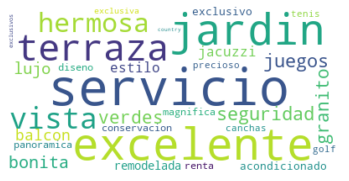

In [43]:
counter_positivas = get_word_counter(df["palabras_positivas_descripcion"])
wc_positivas = get_wordcloud(counter_positivas)

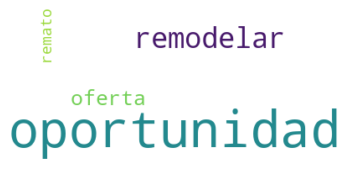

In [44]:
counter_negativas = get_word_counter(df["palabras_negativas_descripcion"])
wc_ngativas = get_wordcloud(counter_negativas)

In [ ]:
plot = get_barplot(df.palabras_negativas_descripcion.value_counts().sort_index(), title="Palabras negativas en descripción", x_label="Cantidad de palabras negativas en descripción", y_label="Cantidad de publicaciones")
plot.figure.savefig("../graficos/barplot_palabras_negativas_descripcion.png")

In [ ]:
plot = get_barplot(df.palabras_positivas_descripcion.value_counts().sort_index(), title="Palabras positivas en descripción", x_label="Cantidad de palabras positivas en descripción", y_label="Cantidad de publicaciones")
plot.figure.savefig("../graficos/barplot_palabras_positivas_descripcion.png")

In [ ]:
df_corr_positivas = df[["descripcion_limpia","precio"]]
for palabra in palabras_positivas:
    df_corr_positivas[palabra] = df_corr_positivas["descripcion_limpia"].map(lambda x: int(palabra in x))
df_corr_positivas.corr()["precio"].sort_values(ascending=False)

In [ ]:
df_corr_negativas = df[["descripcion_limpia","precio"]]
for palabra in palabras_negativas:
    df_corr_negativas[palabra] = df_corr_negativas["descripcion_limpia"].map(lambda x: int(palabra in x))
df_corr_negativas.corr()["precio"].sort_values(ascending=True)

In [ ]:
test = df[["descripcion_limpia","precio","metrostotales"]]
for palabra in palabras_positivas:
    test[palabra] = test["descripcion_limpia"].map(lambda x: int(palabra in x))

In [ ]:
top = list(set(test.corr()["metrostotales"].sort_values(ascending=False).head(8).index).union(set(test.corr()["precio"].sort_values(ascending=False).head(8).index)))

In [ ]:
test_corr = test[top].corr()
test_corr["dif"] = test_corr["precio"] - test_corr["metrostotales"]
test_corr["dif"] = abs(test_corr["dif"])

In [ ]:
test_corr["dif"].sort_values(ascending=False)
#estas se me ocurre que serian las palabras que mayor diferencia podrian hacer

In [ ]:
test_corr

In [ ]:
con_descripcion_y_titulo = df.loc[(df["len_descripcion"]>0) & (df["len_titulo"]>0)]

In [ ]:
con_descripcion_y_titulo["titulo_descripcion"] = con_descripcion_y_titulo["titulo_limpio"] + "_" + con_descripcion_y_titulo["descripcion_limpia"]
con_descripcion_y_titulo["tiene_duplicado"] = con_descripcion_y_titulo["titulo_descripcion"].duplicated(keep=False)

In [ ]:
duplicadas = con_descripcion_y_titulo.loc[con_descripcion_y_titulo["tiene_duplicado"]].sort_values(by="titulo_descripcion")

In [ ]:
grouped = duplicadas.groupby(["titulo_descripcion"]).agg({"fecha":"nunique", "precio": ["nunique", "mean", "max", "min"]})

In [ ]:
grouped.columns = [x+"_"+y for x,y in grouped.columns]

In [ ]:
grouped["precio_dif"] = (grouped["precio_max"] - grouped["precio_min"]).astype(int)

In [ ]:
grouped["precio_dif"].describe()

In [ ]:
grouped.loc[grouped["precio_dif"]>grouped["precio_dif"].mean()].sort_values(by="precio_nunique", ascending=False)

In [ ]:
con_descripcion_y_titulo.loc[con_descripcion_y_titulo["titulo_descripcion"]=="venta casa tijuana_lote manzana nocnok encuentra vivienda"].head(2)

In [ ]:
con_descripcion_y_titulo.loc[con_descripcion_y_titulo["titulo_descripcion"]=="venta casa chihuahua_nocnok tipo credito contado venta posesion fisica ningun acepta exclusiva"].head(2)